In [56]:
import numpy as np
from CoolProp.CoolProp import PropsSI
import handcalcs.render
from handcalcs.decorator import handcalc
import pint
import endf
from numpy import pi
from numpy import sqrt, log
import os
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import fluids

ureg = pint.UnitRegistry(auto_reduce_dimensions=True)
ureg.default_format = "~P"
Q_ = ureg.Quantity
ureg.define('USD = [currency] = $')

In [57]:
# Input parameters
Af = 3740
Bf = 0.8655
Ac = 3380
Bc = 0.84
kf = 0.5
Tboilf = 1837
Tmeltf = 738
Tmeltc = 698
kc = 0.7

# Define density expansion
def rhof(T):
    return Af - Bf*T

def rhoc(T):
    return Ac - Bc*T

# Define volumetric thermal expansion coef (beta)
def betaf(T):
    return Bf/(Af - Bf*T)

def betac(T):
    return Bc/(Ac - Bc*T)

print(betac(1000))

# Define viscosity of coolant
def nuc(T):
    return 1E-03*0.161*np.exp(26400/(8.314*T))

# Define heat capacity of coolant
def cpc(T):
    return 363.10 + 0.19*T

/tmp/ipykernel_67132/3795400902.py:45: RuntimeWarning: divide by zero encountered in scalar divide
  print(ro*2/L > 35/(GrL(Teval, hguess, qgen, ro)))


False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
Tru

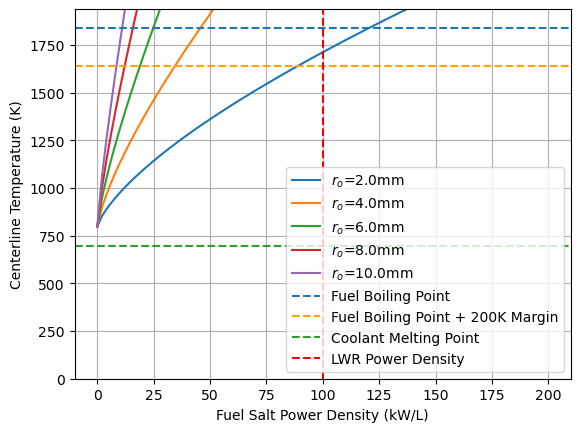

In [58]:
g = 9.8
Tinf = Tmeltc + 100 # 100K over melting temp
L = 2.6 # meters

# Initial guess of h: since the Rayleigh number depends on h, 
h = 1 # W/m2K

def Ts(h, qgen, ro):
    return Tinf + qgen*ro/(2*h)

def centerlineTemp(Ts, qgen, ro):
    return qgen*ro**2/(4*kf) + Ts

def alphac(T):
    return kc/(cpc(T)*rhoc(T))

# Dimensionless numbers
def Pr(T):
    return nuc(T)/(alphac(T))

def RaL(T, h, qgen, ro):
    return g*betac(T)*(Ts(h, qgen, ro) - Tinf)*L**3/(alphac(T)*nuc(T))

def GrL(T, h, qgen, ro):
    return RaL(T, h, qgen, ro)/Pr(T)

def NuL(T, h, qgen, ro):
    return (0.825 + 0.387*RaL(T, h, qgen, ro)**(1/6)/(1+(0.492/Pr(T))**(9/16))**(8/27))**2

# Need two loops, one over volumetric  heat generation rate (in W/m3) and one for fuel pin radius ro
qgens = np.linspace(0, 200E+06, 100) # W/m3
ros = np.linspace(0.002, 0.01, 5) # 2mm-10mm

for ro in ros:
    centerlineTemps = np.zeros(len(qgens))
    for index, qgen in enumerate(qgens):
        hguess = 1 # initial guess of h
        Tsguess = 500 # initial guess of surface temp
        for i in range(100):
            Teval = 1/2*(Tsguess + Tinf) # Properties evaluated at average temp
            Nu = NuL(Teval, hguess, qgen, ro)
            hguess = kc/L*Nu # Update guess of h
            Tsguess = Ts(hguess, qgen, ro)
        centerlineTemps[index] = centerlineTemp(Tsguess, qgen, ro)
        print(ro*2/L > 35/(GrL(Teval, hguess, qgen, ro)))

    plt.plot(qgens/(1E+06), centerlineTemps, label=f'$r_o$={ro*1E+03}mm')
plt.grid()
plt.ylim(0,Tboilf+100)
plt.axhline(Tboilf, label='Fuel Boiling Point', linestyle='dashed')
plt.axhline(Tboilf-200, label='Fuel Boiling Point + 200K Margin', linestyle='dashed', color='orange')
plt.axhline(Tmeltc, label='Coolant Melting Point', linestyle='dashed', color='tab:green')
plt.axvline(100, label='LWR Power Density', linestyle='dashed', color='red')
plt.axvline
plt.xlabel('Fuel Salt Power Density (kW/L)')
plt.ylabel('Centerline Temperature (K)')
plt.legend()
plt.savefig('results.png', dpi=300)